In [1]:
"""
Code adapted from: https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/
"""
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

In [154]:
def running_mean(vals, n=10):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

In [161]:
# state A
STATE_A = 0

# state B
STATE_B = 1

# use one terminal state
STATE_TERMINAL = 2

# starts from state A
STATE_START = STATE_A

# possible actions in A
ACTION_A_RIGHT = 0
ACTION_A_LEFT = 1

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.2

# discount for max value
GAMMA = 1.0

# possible actions in B, maybe 10 actions
ACTIONS_B = range(0, 10)

# mean of action rewards at state B
MEAN_REWARD = 0.1
if MEAN_REWARD < 0:
    SIGN = 'neg'
else:
    SIGN = 'pos'
# all possible actions
STATE_ACTIONS = [[ACTION_A_RIGHT, ACTION_A_LEFT], ACTIONS_B]

# state action pair values, if a state is a terminal state, then the value is always 0
INITIAL_Q = [np.zeros(2), np.zeros(len(ACTIONS_B)), np.zeros(1)]

# set up destination for each state and each action
TRANSITION = [[STATE_TERMINAL, STATE_B], [STATE_TERMINAL] * len(ACTIONS_B)]

# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(STATE_ACTIONS[state])
    else:
        values_ = q_value[state]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

# take @action in @state, return the reward
def take_action(state, action):
    if state == STATE_A:
        return 0
    return np.random.normal(MEAN_REWARD, 1)

# if there are two state action pair value array, use double Q-Learning
# otherwise use normal Q-Learning
def q_learning(q1, q2=None):
    state = STATE_START
    # track the # of action left in state A
    left_count = 0
    cum_reward = 0
    while state != STATE_TERMINAL:
        if q2 is None:
            action = choose_action(state, q1)
        else:
            # derive a action form Q1 and Q2
            action = choose_action(state, [item1 + item2 for item1, item2 in zip(q1, q2)])
        if state == STATE_A and action == ACTION_A_LEFT:
            left_count += 1
        reward = take_action(state, action)
        cum_reward += reward
        next_state = TRANSITION[state][action]
        if q2 is None:
            active_q = q1
            target = np.max(active_q[next_state])
        else:
            if np.random.binomial(1, 0.5) == 1:
                active_q = q1
                target_q = q2
            else:
                active_q = q2
                target_q = q1
            best_action = np.random.choice([action_ for action_, value_ in enumerate(active_q[next_state]) if value_ == np.max(active_q[next_state])])
            target = target_q[next_state][best_action]

        # Q-Learning update
        active_q[state][action] += ALPHA * (
            reward + GAMMA * target - active_q[state][action])
        state = next_state
    if q2 is not None:
        return left_count, cum_reward, (np.mean(q1[STATE_B]) + np.mean(q2[STATE_B]))/2
    else:
        return left_count, cum_reward, np.mean(q1[STATE_B])

In [162]:
# Figure 6.7, 1,000 runs may be enough, # of actions in state B will also affect the curves

# each independent run has 300 episodes
episodes = 500
runs = 100
left_counts_q = np.zeros((runs, episodes))
left_counts_double_q = np.zeros((runs, episodes))
cum_reward_q = np.zeros((runs, episodes))
cum_reward_double_q = np.zeros((runs, episodes))
Bqvalue_q = np.zeros((runs, episodes))
Bqvalue_double_q = np.zeros((runs, episodes))

for run in tqdm(range(runs)):
    q = copy.deepcopy(INITIAL_Q)
    q1 = copy.deepcopy(INITIAL_Q)
    q2 = copy.deepcopy(INITIAL_Q)
    for ep in range(0, episodes):
        left_counts_q[run, ep], cum_reward_q[run, ep], Bqvalue_q[run, ep] = q_learning(q)
        left_counts_double_q[run, ep], cum_reward_double_q[run, ep], Bqvalue_double_q[run, ep] = q_learning(q1, q2)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.91it/s]

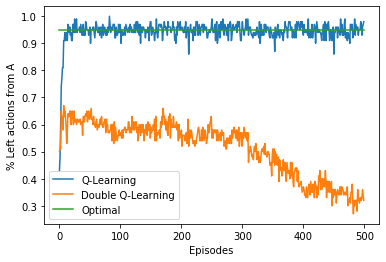

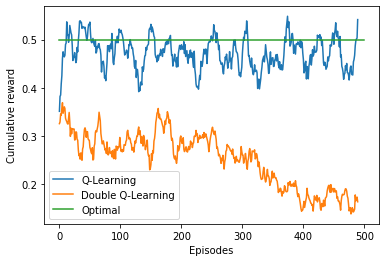

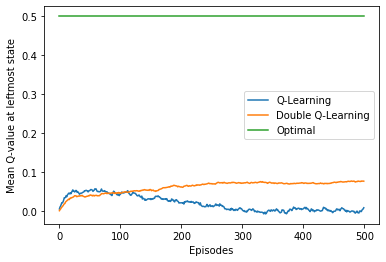

In [163]:
left_counts_q_mean = left_counts_q.mean(axis=0)
left_counts_double_q_mean = left_counts_double_q.mean(axis=0)
plt.plot(left_counts_q_mean, label='Q-Learning')
plt.plot(left_counts_double_q_mean, label='Double Q-Learning')
if SIGN == 'neg':
    optimal_line = np.ones(episodes) * EPSILON/2
else:
    optimal_line = 1 - np.ones(episodes) * EPSILON/2
plt.plot(optimal_line, label='Optimal')
plt.xlabel('Episodes')
plt.ylabel('% Left actions from A')
plt.legend()
plt.savefig('images/sc-{}-policy.png'.format(SIGN))
plt.show()
plt.close()

cum_reward_q_mean = cum_reward_q.mean(axis=0)
cum_reward_double_q_mean = cum_reward_double_q.mean(axis=0)
plt.plot(running_mean(cum_reward_q_mean, n=10), label='Q-Learning')
plt.plot(running_mean(cum_reward_double_q_mean, n=10), label='Double Q-Learning')
plt.plot(np.ones(episodes) * np.max([0, MEAN_REWARD]), label='Optimal')
plt.xlabel('Episodes')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('images/sc-{}-cumreward.png'.format(SIGN))
plt.show()
plt.close()

Bqvalue_q_mean = Bqvalue_q.mean(axis=0)
Bqvalue_double_q_mean = Bqvalue_double_q.mean(axis=0)
plt.plot(Bqvalue_q_mean, label='Q-Learning')
plt.plot(Bqvalue_double_q_mean, label='Double Q-Learning')
plt.plot(np.ones(episodes) * MEAN_REWARD, label='Optimal')
plt.xlabel('Episodes')
plt.ylabel('Mean Q-value at leftmost state')
plt.legend()
plt.savefig('images/sc-{}-qval.png'.format(SIGN))
plt.show()
plt.close()


In [42]:
# import numpy as np 
# class SARSA(object):
# 	def __init__(self, *args):
# 		if not args is None:
# 			self.env = args[0]
# 			self.Q = args[1]
# 			self.alpha = args[2]
# 			self.gamma = args[3]
# 			self.epsilon = args[4]
# 			self.n_episodes = args[5]
# 			self.verbose = args[6]
# 			self.record_training = args[7]
# 			self.checkpoint = self.n_episodes * 0.1
# 		else:
# 			print('Invalid arguments.')

# 	def eps_greedy(self, obs):
# 		if np.random.uniform() < self.epsilon:
# 			return np.random.randint(self.env.action_space.n)
# 		else:
# 			action_values = [self.Q[obs, a] for a in 
# 							 range(self.env.action_space.n)]
# 			greedy_idx = np.argwhere(action_values == np.max(action_values))
# 			greedy_act_idx = np.random.choice(greedy_idx.flatten())
# 			return greedy_act_idx

# 	def greedy_action(self, obs):
# 		action_values = [self.Q[obs, a] for a in 
# 						 range(self.env.action_space.n)]
# 		greedy_idx = np.argmax(action_values)
# 		return greedy_idx

# 	def train(self, idx=None, q=None):
# 		if self.record_training:
# 			self.all_rewards = []

# 		for episode in range(self.n_episodes):
# 			done = False
# 			obs = self.env.reset()
# 			if self.record_training:
# 				episode_reward = 0
# 			a = self.eps_greedy(obs)

# 			while not done:
# 				obs_prime, reward, done, info = self.env.step(a)
# 				a_prime = self.eps_greedy(obs_prime)
# 				self.Q[obs,a] += self.alpha * (reward + self.Q[obs_prime, a_prime] -
# 												   self.Q[obs, a])
# 				if self.record_training:
# 					episode_reward += reward
# 				obs = obs_prime
# 				a = a_prime
				
				
# 			if self.record_training:
# 				self.all_rewards.append(episode_reward)
# 			if self.verbose and episode % self.checkpoint == 0:
# 				if not idx is None:
# 					print(f'Agent: {idx} Episode: {episode}')
# 				else:
# 					print(f'Episode: {episode}')
# 		if not q is None:
# 			q.put(self)
# 		if not idx is None:
# 			print(f'Agent: {idx} - Training complete.')
# 		else:
# 			print('Training complete.')
# class QLearning(object):
	
# 	def __init__(self, *args):
# 		if not args is None:
# 			self.env = args[0]
# 			self.Q = args[1]
# 			self.alpha = args[2]
# 			self.gamma = args[3]
# 			self.n_episodes = args[5]
# 			self.verbose = args[6]
# 			self.record_training = args[7]
# 			self.checkpoint = self.n_episodes * 0.1
# 			if isinstance(args[4], float):
# 				self.epsilon = args[4]
# 				self.eps_decay = None
# 			else:
# 				self.eps_decay = eps_decay
# 				self.epsilon = 1.0
# 		else:
# 			print('Invalid arguments.')
			

# 	def eps_greedy(self, obs):
# 		if np.random.uniform() < self.epsilon:
# 			return np.random.randint(self.env.action_space.n)
# 		else:
# 			action_values = [self.Q[obs, a] for a in 
# 							 range(self.env.action_space.n)]
# 			greedy_idx = np.argwhere(action_values == np.max(action_values))
# 			greedy_act_idx = np.random.choice(greedy_idx.flatten())
# 			return greedy_act_idx


# 	def opt_action_val(self, obs):
# 		action_values = [self.Q[obs, a] for a in 
# 						 range(self.env.action_space.n)]
# 		return np.max(action_values)


# 	def greedy_action(self, obs):
# 		action_values = [self.Q[obs, a] for a in 
# 						 range(self.env.action_space.n)]
# 		greedy_idx = np.argmax(action_values)
# 		return greedy_idx


# 	def train(self, idx=None, q=None):
# 		if self.record_training:
# 			self.all_rewards = []

# 		for episode in range(self.n_episodes):
# 			done = False
# 			obs = self.env.reset()
# 			if self.record_training:
# 				episode_reward = 0
			
# 			while not done:
# 				a = self.eps_greedy(obs)
# 				obs_prime, reward, done, info = self.env.step(a)
# 				self.Q[obs,a] += self.alpha * (reward + self.gamma *
# 									   self.opt_action_val(obs_prime) - 
# 									   self.Q[obs,a])
# 				obs = obs_prime
# 				if self.record_training:
# 					episode_reward += reward
# 			if self.record_training:
# 				self.all_rewards.append(episode_reward)
# 			if not self.eps_decay is None:
# 				self.epsilon = self.eps_decay(self.epsilon)
# 			if self.verbose and episode % self.checkpoint == 0:
# 				if not idx is None:
# 					print(f'Agent: {idx} Episode: {episode}')
# 				else:
# 					print(f'Episode: {episode}')
# 		if not q is None:
# 			q.put(self)
# 		if not idx is None:
# 			print(f'Agent: {idx} - Training complete.')
# 		else:
# 			print('Training complete.')


Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000
Training complete.


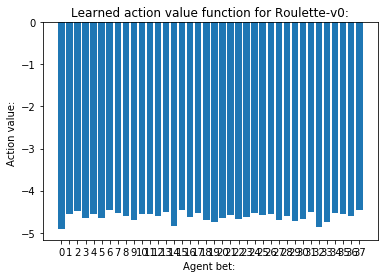

In [75]:
# # Created by Tristan Bester.
# import gym
# import numpy as np 
# from itertools import product

# # Initialize environment, hyperparameters and action value function.
# gamma = 1
# alpha = 0.1
# epsilon = 0.1
# n_epsiodes = 10000
# env = gym.make('Roulette-v0')
# Q = dict.fromkeys(product([0], range(38)), 0.0)

# # Create and train agent.
# agent = SARSA(env, Q, alpha, gamma, epsilon, n_epsiodes, True, False)
# agent.train()

# final_Q_table = agent.Q

# # Plot the learned action value function.
# action_values = np.array([i for i in agent.Q.values()])
# plt.bar(range(len(action_values)), action_values)
# plt.xticks(range(len(action_values)))
# plt.xlabel('Agent bet: ')
# plt.ylabel('Action value: ')
# plt.title('Learned action value function for Roulette-v0:')
# plt.show()

In [36]:
"{(0, 0): 7.837448250664876, (0, 1): 9.134657024397288, (0, 2): 8.53790450151374, (0, 3): 9.080151290921476, (0, 4): 8.837983570705312, (0, 5): 7.897240055067082, (0, 6): 8.756061883817393, (0, 7): 8.658906960595443, (0, 8): 9.016713100140318, (0, 9): 9.13894600069668, (0, 10): 8.84725873531183, (0, 11): 8.696801813820795, (0, 12): 8.345543379505015, (0, 13): 8.797761812846572, (0, 14): 8.344227047859585, (0, 15): 8.87889005408407, (0, 16): 8.369601654341249, (0, 17): 8.266849275657306, (0, 18): 8.720561481251002, (0, 19): 8.860823928735927, (0, 20): 9.136187564267125, (0, 21): 8.807223939561785, (0, 22): 8.844722108276683, (0, 23): 9.112817302990603, (0, 24): 8.986758557209424, (0, 25): 7.790777778440418, (0, 26): 8.637824926176508, (0, 27): 8.686424697268256, (0, 28): 8.607496456959925, (0, 29): 8.830698987363784, (0, 30): 8.641462921435348, (0, 31): 8.670507480027696, (0, 32): 8.431972784443593, (0, 33): 8.505773585619899, (0, 34): 8.370897013149078, (0, 35): 8.58824337819527, (0, 36): 9.137774682044842, (0, 37): 9.143598210481262}"

'{(0, 0): 7.837448250664876, (0, 1): 9.134657024397288, (0, 2): 8.53790450151374, (0, 3): 9.080151290921476, (0, 4): 8.837983570705312, (0, 5): 7.897240055067082, (0, 6): 8.756061883817393, (0, 7): 8.658906960595443, (0, 8): 9.016713100140318, (0, 9): 9.13894600069668, (0, 10): 8.84725873531183, (0, 11): 8.696801813820795, (0, 12): 8.345543379505015, (0, 13): 8.797761812846572, (0, 14): 8.344227047859585, (0, 15): 8.87889005408407, (0, 16): 8.369601654341249, (0, 17): 8.266849275657306, (0, 18): 8.720561481251002, (0, 19): 8.860823928735927, (0, 20): 9.136187564267125, (0, 21): 8.807223939561785, (0, 22): 8.844722108276683, (0, 23): 9.112817302990603, (0, 24): 8.986758557209424, (0, 25): 7.790777778440418, (0, 26): 8.637824926176508, (0, 27): 8.686424697268256, (0, 28): 8.607496456959925, (0, 29): 8.830698987363784, (0, 30): 8.641462921435348, (0, 31): 8.670507480027696, (0, 32): 8.431972784443593, (0, 33): 8.505773585619899, (0, 34): 8.370897013149078, (0, 35): 8.58824337819527, (0, 3